# Problema do Transporte (PT)

In [58]:
import cplex
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Leitura e pré-processamento dos dados

In [59]:
file = "in_pt.txt"

oferta = []
demanda = []
custos = []

with open(file, 'r') as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = list(filter(None, lines))

num_nodes, num_edges = map(int, lines[0].strip().split())

for line in lines[1:num_nodes + 1]:
    node_id, value = map(int, line.strip().split())
    if value > 0:
        oferta.append(value)
    else:
        demanda.append(abs(value))

num_oferta = len(oferta)
num_demanda = len(demanda)

custos = [[0] * (num_nodes - num_oferta) for _ in range(num_oferta)]
for line in lines[num_nodes + 1:]:
    source, target, cost = map(int, line.strip().split())
    if source < num_oferta and target >= num_oferta:
        custos[source][target - num_oferta] = cost

fornecedores = [f'F{i+1}' for i in range(len(oferta))]
clientes = [f'C{j+1}' for j in range(len(demanda))]

print("Fornecedores:", fornecedores)
print("Clientes:", clientes)
print("Oferta:", oferta)
print("Demanda:", demanda)
print("Custos:", custos)

Fornecedores: ['F1', 'F2', 'F3']
Clientes: ['C1', 'C2', 'C3', 'C4']
Oferta: [30, 50, 40]
Demanda: [20, 28, 25, 34]
Custos: [[14, 16, 13, 18], [8, 9, 10, 11], [18, 16, 21, 20]]


In [60]:
df = pd.DataFrame(custos, index=fornecedores, columns=clientes)
df['Oferta'] = oferta
df.loc['Demanda'] = demanda + [np.nan]
print(df)

           C1    C2    C3    C4  Oferta
F1       14.0  16.0  13.0  18.0    30.0
F2        8.0   9.0  10.0  11.0    50.0
F3       18.0  16.0  21.0  20.0    40.0
Demanda  20.0  28.0  25.0  34.0     NaN


## Visualização do problema

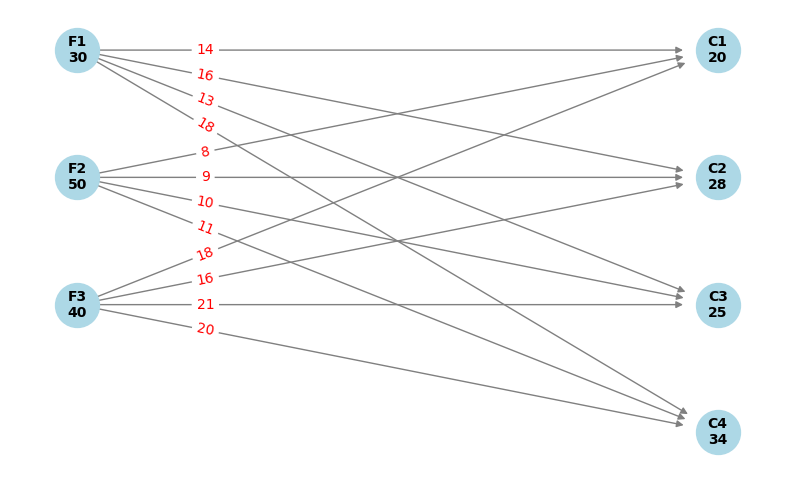

In [61]:
G = nx.DiGraph()

# Adiciona nós dos fornecedores com o atributo 'oferta'
for i, f in enumerate(fornecedores):
    G.add_node(f, oferta=oferta[i])

# Adiciona nós dos clientes com o atributo 'demanda'
for j, c in enumerate(clientes):
    G.add_node(c, demanda=demanda[j])

# Adiciona as arestas (de fornecedores para clientes) com os custos como peso
for i, f in enumerate(fornecedores):
    for j, c in enumerate(clientes):
        G.add_edge(f, c, weight=custos[i][j])

pos = {}
for idx, f in enumerate(fornecedores):
    pos[f] = (0, -idx)
for idx, c in enumerate(clientes):
    pos[c] = (1, -idx)

node_labels = {}
for node, attr in G.nodes(data=True):
    if 'oferta' in attr:
        node_labels[node] = f"{node}\n{attr['oferta']}"
    elif 'demanda' in attr:
        node_labels[node] = f"{node}\n{attr['demanda']}"

edge_labels = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')
nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>',
    arrowsize=10,
    min_target_margin = 25,
    edge_color='gray'
    )
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.8, font_color='red')

plt.axis('off')
plt.show()

## Modelagem e solução

In [62]:
# Criação do model
model = cplex.Cplex()
model.set_problem_type(cplex.Cplex.problem_type.LP)
model.objective.set_sense(model.objective.sense.minimize)

# Nomes das variáveis de decisão
variaveis = []
for i in range(num_oferta):
    for j in range(num_demanda):
        variaveis.append(f"x{i+1}{j+1}")

# Coeficientes da função objetivo (custos de transporte)
objetivo = [custos[i][j] for i in range(num_oferta) for j in range(num_demanda)]

# Adiciona as variáveis ao model
model.variables.add(names=variaveis, obj=objetivo, lb=[0] * len(variaveis))

# Restrições de oferta: a soma das quantidades enviadas por cada fornecedor não pode exceder sua oferta
for i in range(num_oferta):
    indices = [i * num_demanda + j for j in range(num_demanda)]
    valores = [1] * num_demanda
    model.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=indices, val=valores)],
        senses=["L"],
        rhs=[oferta[i]]
    )

# Restrições de demanda: a soma das quantidades recebidas por cada cliente deve ser igual à sua demanda
for j in range(num_demanda):
    indices = [i * num_demanda + j for i in range(num_oferta)]
    valores = [1] * num_oferta
    model.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=indices, val=valores)],
        senses=["E"],
        rhs=[demanda[j]]
    )

%time model.solve()

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.00 sec. (0.01 ticks)
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =          1207.000000
CPU times: user 18.7 ms, sys: 516 µs, total: 19.2 ms
Wall time: 18.5 ms


## Sumário dos resultados

In [63]:
status = model.solution.get_status()
if status == model.solution.status.optimal:
    print("Status da solução:", model.solution.get_status_string())
    print(f"Custo total de transporte: {model.solution.get_objective_value()}")

    so_vars = {var: model.solution.get_values(var) for var in variaveis}
    for i in range(num_oferta):
        for j in range(num_demanda):
            quantidade = model.solution.get_values(i * num_demanda + j)
            if quantidade > 0:
                print(f"Quantidade transportada de {fornecedores[i]} para {clientes[j]}: {quantidade}")

    model.write("./output/model_pt.lp")
    model.solution.write("./output/solution_pt.sol")
else:
    print("No Solution.")

Default row names c1, c2 ... being created.


Status da solução: optimal
Custo total de transporte: 1330.0
Quantidade transportada de F1 para C1: 5.0
Quantidade transportada de F1 para C3: 25.0
Quantidade transportada de F2 para C1: 15.0
Quantidade transportada de F2 para C2: 1.0
Quantidade transportada de F2 para C4: 34.0
Quantidade transportada de F3 para C2: 27.0


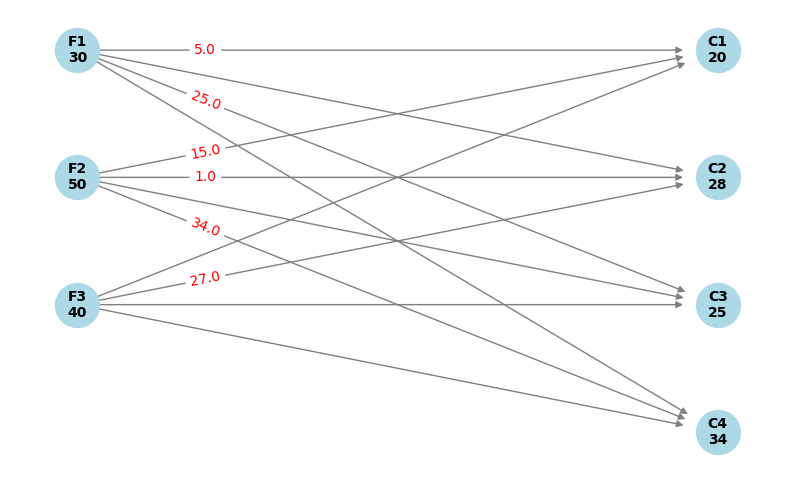

In [64]:
if status == model.solution.status.optimal:
    for i, f in enumerate(fornecedores):
        for j, c in enumerate(clientes):
            var = f"x{i+1}{j+1}"
            flow = so_vars[var]
            if G.has_edge(f, c):
                G[f][c]['flow'] = flow

    pos = {}
    for idx, f in enumerate(fornecedores):
        pos[f] = (0, -idx)
    for idx, c in enumerate(clientes):
        pos[c] = (1, -idx)

    node_labels = {}
    for node, attr in G.nodes(data=True):
        if 'oferta' in attr:
            node_labels[node] = f"{node}\n{attr['oferta']}"
        elif 'demanda' in attr:
            node_labels[node] = f"{node}\n{attr['demanda']}"

    edge_labels = {}
    for u, v, data in G.edges(data=True):
        flow = data.get('flow', 0)
        if flow > 0:
            edge_labels[(u, v)] = f"{flow}"
        else:
            edge_labels[(u, v)] = ""

    plt.figure(figsize=(10, 6))
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle='-|>',
        arrowsize=10,
        min_target_margin = 25,
        edge_color='gray'
        )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.8, font_color='red')

    plt.axis('off')
    plt.show()

else:
    print("No Solution. No Graph for you.")